In [1]:
%tensorflow_version 2.x

In [2]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-04-26 20:23:06--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   101MB/s    in 2.3s    

2021-04-26 20:23:09 (101 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [3]:
!rm -rf checkpoints

In [4]:
!mkdir checkpoints

In [5]:
import cv2
import numpy as np
import tensorflow as tf

from absl import logging
from itertools import repeat
from google.colab.patches import cv2_imshow

from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [6]:
print(tf.__version__)

2.4.1


In [7]:
yolo_iou_threshold   = 0.6 # iou threshold
yolo_score_threshold = 0.6 # score threshold

weightsyolov3 = 'yolov3.weights' # path to weights file
weights= 'checkpoints/yolov3.tf' # path to checkpoints file
size= 416             #resize images to\
checkpoints = 'checkpoints/yolov3.tf'
num_classes = 80      # number of classes in the model

In [8]:
YOLO_V3_LAYERS = [
  'yolo_darknet',
  'yolo_conv_0',
  'yolo_output_0',
  'yolo_conv_1',
  'yolo_output_1',
  'yolo_conv_2',
  'yolo_output_2',
]

In [9]:
def load_darknet_weights(model, weights_file):
  wf = open(weights_file, 'rb')
  major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
  layers = YOLO_V3_LAYERS

  for layer_name in layers:
    sub_model = model.get_layer(layer_name)
    for i, layer in enumerate(sub_model.layers):
      if not layer.name.startswith('conv2d'):
        continue
      batch_norm = None
      if i + 1 < len(sub_model.layers) and \
            sub_model.layers[i + 1].name.startswith('batch_norm'):
        batch_norm = sub_model.layers[i + 1]

      logging.info("{}/{} {}".format(
        sub_model.name, layer.name, 'bn' if batch_norm else 'bias'))

      filters = layer.filters
      size = layer.kernel_size[0]
      in_dim = layer.input_shape[-1]

      if batch_norm is None:
        conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
      else:
        bn_weights = np.fromfile(
          wf, dtype=np.float32, count=4 * filters)

        bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

      conv_shape = (filters, in_dim, size, size)
      conv_weights = np.fromfile(
        wf, dtype=np.float32, count=np.product(conv_shape))

      conv_weights = conv_weights.reshape(
        conv_shape).transpose([2, 3, 1, 0])

      if batch_norm is None:
        layer.set_weights([conv_weights, conv_bias])
      else:
        layer.set_weights([conv_weights])
        batch_norm.set_weights(bn_weights)

  assert len(wf.read()) == 0, 'failed to read all data'
  wf.close()

In [10]:
def interval_overlap(interval_1, interval_2):
  x1, x2 = interval_1
  x3, x4 = interval_2
  if x3 < x1:
    return 0 if x4 < x1 else (min(x2,x4) - x1)
  else:
    return 0 if x2 < x3 else (min(x2,x4) - x3)

def intersectionOverUnion(box1, box2):
  intersect_w = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
  intersect_h = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
  intersect_area = intersect_w * intersect_h
  
  w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
  w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
  
  union_area = w1*h1 + w2*h2 - intersect_area
  return float(intersect_area) / union_area

In [11]:
def draw_outputs(img, outputs, class_names):
  boxes, score, classes, nums = outputs
  boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]
  wh = np.flip(img.shape[0:2])
  for i in range(nums):
    x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
    img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
    img = cv2.putText(img, '{} {:.4f}'.format(
      class_names[int(classes[i])], score[i]),
      x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
  return img

In [12]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
  def call(self, x, training=False):
    if training is None: training = tf.constant(False)
    training = tf.logical_and(training, self.trainable)
    return super().call(x, training)

In [13]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

In [14]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
  if strides == 1:
    padding = 'same'
  else:
    x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
    padding = 'valid'
  x = Conv2D(filters=filters, kernel_size=size,
          strides=strides, padding=padding,
          use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
  if batch_norm:
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
  return x

def DarknetResidual(x, filters):
  previous  = x
  x = DarknetConv(x, filters // 2, 1)
  x = DarknetConv(x, filters, 3)
  x = Add()([previous , x])
  return x


def DarknetBlock(x, filters, blocks):
  x = DarknetConv(x, filters, 3, strides=2)
  for _ in repeat(None, blocks):
    x = DarknetResidual(x, filters)       
  return x


def Darknet(name=None):
  x = inputs = Input([None, None, 3])
  x = DarknetConv(x, 32, 3)
  x = DarknetBlock(x, 64, 1)
  x = DarknetBlock(x, 128, 2)
  x = x_36 = DarknetBlock(x, 256, 8)
  x = x_61 = DarknetBlock(x, 512, 8)
  x = DarknetBlock(x, 1024, 4)
  return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [15]:
def YoloConv(filters, name=None):
  def yolo_conv(x_in):
    if isinstance(x_in, tuple):
      inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
      x, x_skip = inputs

      x = DarknetConv(x, filters, 1)
      x = UpSampling2D(2)(x)
      x = Concatenate()([x, x_skip])
    else:
      x = inputs = Input(x_in.shape[1:])

    x = DarknetConv(x, filters, 1)
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, filters, 1)
    return Model(inputs, x, name=name)(x_in)
  return yolo_conv

In [16]:
def YoloOutput(filters, anchors, classes, name=None):
  def yolo_output(x_in):
    x = inputs = Input(x_in.shape[1:])
    x = DarknetConv(x, filters * 2, 3)
    x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
    x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
    return tf.keras.Model(inputs, x, name=name)(x_in)
  return yolo_output

In [17]:
def yolo_boxes(pred, anchors, classes):
  grid_size = tf.shape(pred)[1]
  box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1)

  box_xy = tf.sigmoid(box_xy)
  score = tf.sigmoid(score)
  class_probs = tf.sigmoid(class_probs)
  pred_box = tf.concat((box_xy, box_wh), axis=-1)

  grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
  grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

  box_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32)
  box_wh = tf.exp(box_wh) * anchors

  box_x1y1 = box_xy - box_wh / 2
  box_x2y2 = box_xy + box_wh / 2
  bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

  return bbox, score, class_probs, pred_box

In [18]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
  boxes, conf, out_type = [], [], []

  for output in outputs:
    boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
    conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
    out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

  bbox = tf.concat(boxes, axis=1)
  confidence = tf.concat(conf, axis=1)
  class_probs = tf.concat(out_type, axis=1)

  scores = confidence * class_probs
  
  boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
    boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
    scores=tf.reshape(
        scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
    max_output_size_per_class=100,
    max_total_size=100,
    iou_threshold=yolo_iou_threshold,
    score_threshold=yolo_score_threshold
  )
  
  return boxes, scores, classes, valid_detections

In [19]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
          masks=yolo_anchor_masks, classes=80, training=False):
  x = inputs = Input([size, size, channels])

  x_36, x_61, x = Darknet(name='yolo_darknet')(x)

  x = YoloConv(512, name='yolo_conv_0')(x)
  output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

  x = YoloConv(256, name='yolo_conv_1')((x, x_61))
  output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

  x = YoloConv(128, name='yolo_conv_2')((x, x_36))
  output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

  if training:
    return Model(inputs, (output_0, output_1, output_2), name='yolov3')

  boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
  boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
  boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

  outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

  return Model(inputs, outputs, name='yolov3')

In [20]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        # 1. transform all pred outputs
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. transform all true outputs
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)

        # 4. calculate all masks
        obj_mask = tf.squeeze(true_obj, -1)
        # ignore false positive when iou is over threshold
        true_box_flat = tf.boolean_mask(true_box, tf.cast(obj_mask, tf.bool))
        best_iou = tf.reduce_max(broadcast_iou(
            pred_box, true_box_flat), axis=-1)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. calculate all losses
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss
        # TODO: use binary_crossentropy instead
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. sum over (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [21]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

  N = tf.shape(y_true)[0]

  y_true_out = tf.zeros(
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

  anchor_idxs = tf.cast(anchor_idxs, tf.int32)

  indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
  updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
  idx = 0
  for i in tf.range(N):
    for j in tf.range(tf.shape(y_true)[1]):
      if tf.equal(y_true[i][j][2], 0):
        continue
      anchor_eq = tf.equal(
        anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

      if tf.reduce_any(anchor_eq):
        box = y_true[i][j][0:4]
        box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

        anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
        grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

        indexes = indexes.write(
            idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
        updates = updates.write(
          idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
        idx += 1

  return tf.tensor_scatter_nd_update(
    y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes):
  outputs = []
  grid_size = 13

  anchors = tf.cast(anchors, tf.float32)
  anchor_area = anchors[..., 0] * anchors[..., 1]
  box_wh = y_train[..., 2:4] - y_train[..., 0:2]
  box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
  box_area = box_wh[..., 0] * box_wh[..., 1]
  intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
    tf.minimum(box_wh[..., 1], anchors[..., 1])
  iou = intersection / (box_area + anchor_area - intersection)
  anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
  anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

  y_train = tf.concat([y_train, anchor_idx], axis=-1)

  for anchor_idxs in anchor_masks:
    outputs.append(transform_targets_for_output(
      y_train, grid_size, anchor_idxs, classes))
    grid_size *= 2

  return tuple(outputs) # [x, y, w, h, obj, class]


def preprocess_image(x_train, size):
  return (tf.image.resize(x_train, (size, size))) / 255

In [22]:
yolo = YoloV3(classes=num_classes)

load_darknet_weights(yolo, weightsyolov3)

yolo.save_weights(checkpoints)

class_names =  ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
  "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
  "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
  "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
  "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
  "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
  "banana","apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
  "cake","chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop",
  "mouse","remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
  "refrigerator","book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [23]:
from google.colab import files

image = files.upload()
image = list(image.keys())[0]
image = cv2.imread(image)

name = 'test.jpg'     # path to test image
cv2.imwrite(name, image)

Saving france-traffic.jpg to france-traffic.jpg


True

In [24]:
img = tf.image.decode_image(open(name, 'rb').read(), channels=3)
img = tf.expand_dims(img, 0)
img = preprocess_image(img, size)

In [25]:
boxes, scores, classes, nums = yolo(img) #eager mode

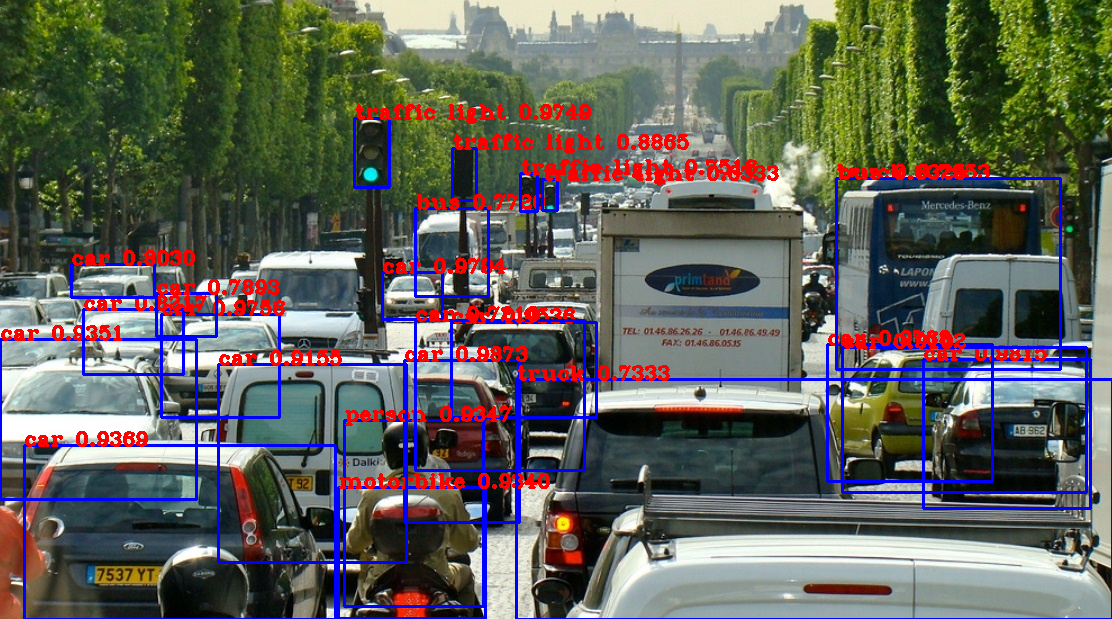

In [26]:
img = cv2.imread(name)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
cv2.imwrite('output.jpg', img)

cv2_imshow(img)